In [25]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import CSVLogger, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
#import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, Lambda, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.utils import Progbar
from tensorflow.keras.models import clone_model
from qkeras import *
from qkeras.utils import model_save_quantized_weights
import shutil

# Local imports
# sys.path.insert(1, './directional-pixel-detectors/multiclassifier/')
# from hep_utils import plot_pt_filter, get_number_of_tracks, get_bkg_rej
from utils import *

In [26]:
sizes = ['50x12P5']
# Global variables
threshold = 0.2
pixel_arrayX = 21 #16 #
pixel_arrayY = 13 #16 #
noise_threshold = 0
sensor_geom = '50x12P5'
prefix='dataset_8'
dataset_name = f'{prefix}_{noise_threshold}NoiseThresh' # for save loc of final datasets
# dataset_name = f'dataset_2sNoise_16x16_50x12P5_100e-sigma_{noise_threshold}NoiseThresh' # for save loc of final datasets
thresholds = [0.2]
mode_suffix = '0'
# store all results in this dir:
results_dir = f'{dataset_name}/model{mode_suffix}_results/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
if not os.path.exists(results_dir+'images/'):
    os.makedirs(results_dir+'images/')
if not os.path.exists(results_dir+'csv/'):
    os.makedirs(results_dir+'csv/')

prime_num = [2,3,5,7,11,13,17,19,23,29]

for run_iter in range(1):
    for size_iter in sizes:
        for threshold in thresholds:
            tf.random.set_seed(prime_num[run_iter])
            # sensor_geom = size_iter
            print("=============================")
            # print("Run "+str(run_iter)+": Training model for ",sensor_geom," at pT boundary = ",threshold)
            df1 = pd.read_csv('./'+dataset_name+'/FullPrecisionInputTrainSet_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
            print("Shape of train dataset = ",df1.shape)
            df2 = pd.read_csv('./'+dataset_name+'/TrainSetLabel_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
            print("Shape of train-label set = ",df2.shape)
            df3 = pd.read_csv('./'+dataset_name+'/FullPrecisionInputTestSet_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
            print("Shape of test dataset = ",df3.shape)
            df4 = pd.read_csv('./'+dataset_name+'/TestSetLabel_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
            print("Shape of test-label set = ",df4.shape)
            X_train = df1.values
            X_test = df3.values
            y_train = df2.values
            y_test = df4.values
            
            # zero-padding
            if pixel_arrayY != 16:
                pad_width = ((0, 0), (0, 16 - X_train.shape[1]))
                X_train = np.pad(X_train, pad_width=pad_width, mode='constant')
                pad_width = ((0, 0), (0, 16 - X_test.shape[1]))
                X_test = np.pad(X_test, pad_width=pad_width, mode='constant')
            #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)
            print("X-train, X-test, Y-train, Y-test shapes (after zero-padding if applicable) = ",X_train.shape, X_test.shape, y_train.shape, y_test.shape)
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

Shape of train dataset =  (68000, 13)
Shape of train-label set =  (68000, 1)
Shape of test dataset =  (687322, 13)
Shape of test-label set =  (687322, 1)
X-train, X-test, Y-train, Y-test shapes (after zero-padding if applicable) =  (68000, 16) (687322, 16) (68000, 1) (687322, 1)


In [27]:
create_fresh_model = True
# create model
shape = 16 # y-profile
nb_classes = 3 # positive low pt, negative low pt, high pt
first_dense = 58 # shape of first dense layer

def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(58, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(58,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense1")(x)
    # x = QDense(58,
    #      kernel_quantizer=quantized_bits(4,0,alpha=1),
    #      bias_quantizer=quantized_bits(4,0,alpha=1),
    #      name="dense1")(x)
    # x = keras.layers.BatchNormalization()(x)
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

if(create_fresh_model == True):  
    models = {}
    qmodels = {}
    
    model_save_name = f'{results_dir}model{mode_suffix}_{prefix}_{sensor_geom}_keras_d58.h5'
    models['d58'] = {
    'prefix': model_save_name,
    'type'  : 'keras',
    'def'   : CreateModel}  
    
    qmodel_save_name = f'{results_dir}model{mode_suffix}_{prefix}_{sensor_geom}_qkeras_foldbatchnorm_d58w4a8.h5'
    qmodel_q_weights_save_name = f'{results_dir}model{mode_suffix}_{prefix}_{sensor_geom}_qkeras_foldbatchnorm_d58w4a8_q_weights.h5'
    qmodels['d58w4a8'] = {
        'prefix': qmodel_save_name,
        'type'  : 'qkeras_foldbatchnorm',
        'def'   : CreateQModel}
    
    chosen_model = 'd58'  # <<< PAY ATTENTION <<<
    chosen_qmodel = 'd58w4a8'  # <<< PAY ATTENTION <<<

    model_prefix = models[chosen_model]['prefix']
    model_def = models[chosen_model]['def']
    model_type = models[chosen_model]['type']

    model = model_def(X_train.shape[1:], y_train.shape[-1])
    model.compile(optimizer=Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
                metrics=[keras.metrics.SparseCategoricalAccuracy()])
    model.summary()


    qmodel_prefix = qmodels[chosen_qmodel]['prefix']
    qmodel_def = qmodels[chosen_qmodel]['def']
    qmodel_type = qmodels[chosen_qmodel]['type']
    qmodel = qmodel_def(X_train.shape[1:], y_train.shape[-1])
    
    qmodel.compile(optimizer=Adam(),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
                  metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    qmodel.summary()

else:
    # load the model
    model_file = "/fasic_home/gdg/research/projects/CMS_PIX_28/directional-pixel-detectors/multiclassifier/models/ds8l6_padded_noscaling_qkeras_foldbatchnorm_d58w4a8model.h5"
    # model_file = "/asic/projects/C/CMS_PIX_28/benjamin/testing/workarea_112024/CMSPIX28_DAQ/spacely/PySpacely/model.h5"
    # model_file = "./model.h5"
    co = {}
    utils._add_supported_quantized_objects(co)
    model = tf.keras.models.load_model(model_file, custom_objects=co)
    # Generate a simple configuration from keras model
    config = hls4ml.utils.config_from_keras_model(model, granularity='name')
    # Convert to an hls model
    output_dir = "newModelWeights"
    hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, output_dir=output_dir)
    hls_model.write()
    # prepare weights
    prepareWeights(os.path.join(output_dir, "firmware/weights/"))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 16)]              0         
                                                                 
 dense1 (Dense)              (None, 58)                986       
                                                                 
 batch_normalization_6 (Bat  (None, 58)                232       
 chNormalization)                                                
                                                                 
 relu1 (Activation)          (None, 58)                0         
                                                                 
 dense2 (Dense)              (None, 3)                 177       
                                                                 
 linear (Activation)         (None, 3)                 0         
                                                           

## Train keras model

In [28]:
es = EarlyStopping(monitor='val_loss',
                    #monitor='val_sparse_categorical_accuracy', 
                    #mode='max', # don't minimize the accuracy!
                    patience=20,
                    restore_best_weights=True)

history = model.fit(X_train,
                y_train,
                callbacks=[es],
                epochs=150, 
                batch_size=512,
                validation_split=0.2,
                shuffle=True,
                verbose=0)

model.save(model_save_name)

/asic/projects/C/CMS_PIX_28/testing/tools/venvs/p3.11.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


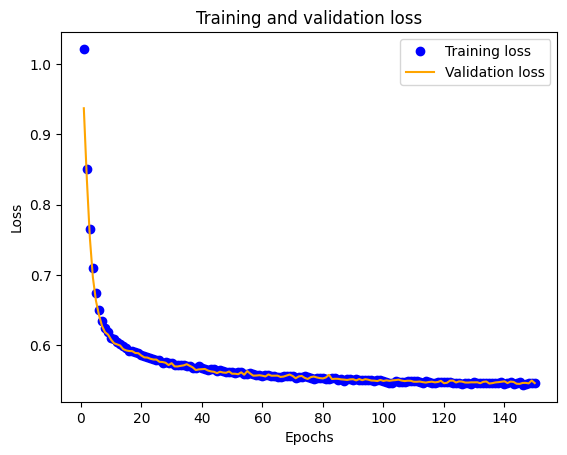

In [29]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{results_dir}images/kerasModel_loss.png')

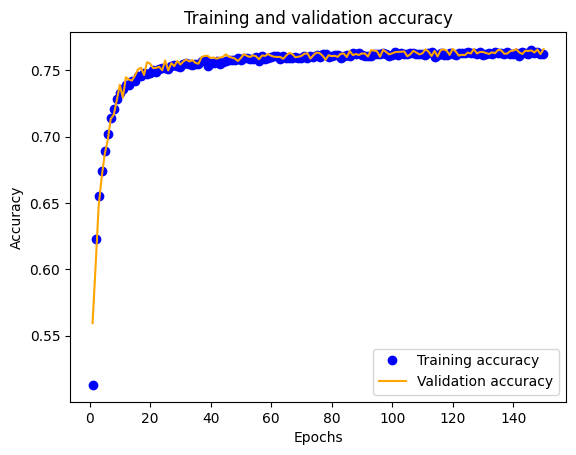

In [30]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#np.max(val_acc)
plt.savefig(f'{results_dir}images/kerasModelAccuracy.png')
plt.show()

21479/21479 [==============================] - 18s 831us/step
dataset_8_0NoiseThresh/model0_results/csv/true.csv
Test loss (Keras) d58: 0.49430692195892334
Test accuracy (Keras) d58: 0.7769865989685059
Confusion matrix:
[[506340  69397  74890]
 [  3790  13680     74]
 [  5112     19  14020]]


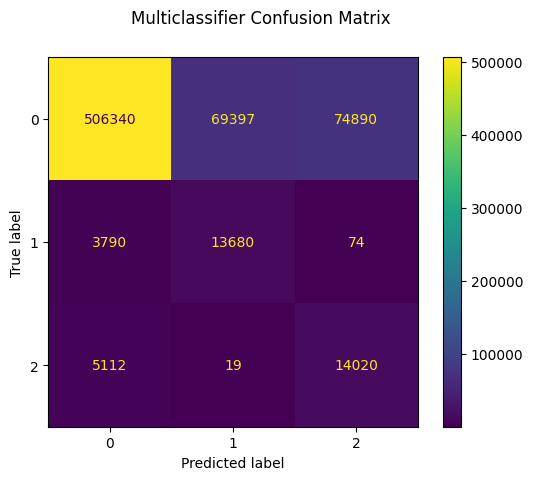

In [31]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)
pd.DataFrame(predictionsFiles).to_csv(f'{results_dir}csv/kerasModelPredictionsFiles.csv', header='predict', index=False)
pd.DataFrame(y_test).to_csv(f'{results_dir}csv/kerasModelTrue.csv', header='true', index=False)
print(f'{results_dir}csv/true.csv')
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss (Keras) {}: {}".format(chosen_model, score[0]))
print("Test accuracy (Keras) {}: {}".format(chosen_model, score[1]))
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig(f'{results_dir}images/kerasModelConfusionMatrix.png')
plt.show()

## QKeras training

In [32]:
qes = EarlyStopping(monitor='val_loss',
                    #monitor='val_sparse_categorical_accuracy', 
                    #mode='max', # don't minimize the accuracy!
                    patience=20,
                    restore_best_weights=True)

qhistory = qmodel.fit(X_train,
                y_train,
                callbacks=[qes],
                epochs=150, 
                batch_size=1024,
                validation_split=0.2,
                shuffle=True,
                verbose=0)

model_save_quantized_weights(qmodel, qmodel_q_weights_save_name)
qmodel.save(qmodel_save_name)
print('Save:', qmodel_save_name)
print('Save:', qmodel_q_weights_save_name)

# from keras_sequential_ascii import keras2ascii
# keras2ascii(qmodel)

... quantizing model
dense1  conv and batchnorm weights cannot be seperately quantized because they will be folded before quantization.
Save: dataset_8_0NoiseThresh/model0_results/model0_dataset_8_50x12P5_qkeras_foldbatchnorm_d58w4a8.h5
Save: dataset_8_0NoiseThresh/model0_results/model0_dataset_8_50x12P5_qkeras_foldbatchnorm_d58w4a8_q_weights.h5


/asic/projects/C/CMS_PIX_28/testing/tools/venvs/p3.11.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


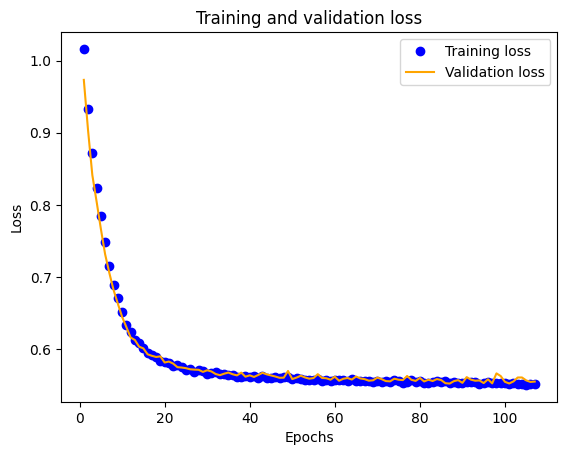

In [33]:
qhistory_dict = qhistory.history
loss_values = qhistory_dict['loss'] 
val_loss_values = qhistory_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{results_dir}images/QkerasModelLoss.png')

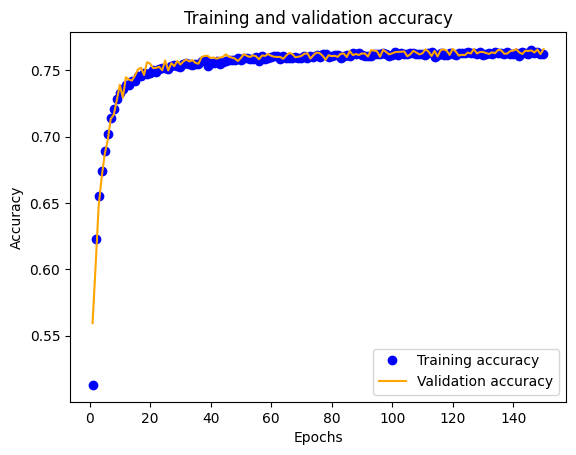

In [34]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#np.max(val_acc)
plt.savefig(f'{results_dir}images/QkerasModelAccuracy.png')
plt.show()

21479/21479 [==============================] - 19s 889us/step
Test loss: 0.5002205967903137
Test accuracy: 0.774284839630127
Confusion matrix:
[[504809  74059  71759]
 [  3652  13819     73]
 [  5526     70  13555]]


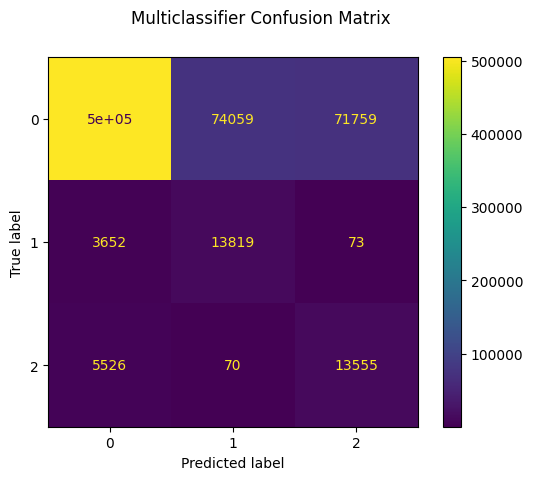

In [35]:
preds = qmodel.predict(X_test) 
predictionsFiles =np.argmax(preds, axis=1)
pd.DataFrame(predictionsFiles).to_csv(f"{results_dir}/csv/QkerasModelPredictionsFiles.csv",header='predict', index=False)
pd.DataFrame(y_test).to_csv(f"{results_dir}/csv/QkerasModelTrue.csv",header='true', index=False)
score = qmodel.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig(f'{results_dir}images/QkerasModelConfusionMatrix.png')
plt.show()

In [36]:
import hls4ml
from fxpmath import Fxp
import os
import csv
def input_to_pixelout(x):
    N_INFERENCES = x.shape[0]

    # first create compout
    encoder_values_Ninferences = []
    for i in range(N_INFERENCES):
        encoder_values = []
        for j in range(16):
            a = x[i][j]
            encoder_sum = []
            if(a==0):
                encoder_sum = [0 for _ in range(16)]
                encoder_sum.reverse()
                
            elif(a==1):
                encoder_sum = [1]+[0 for _ in range(15)]
                encoder_sum.reverse()

            elif(a==2):
                encoder_sum = [2]+[0 for _ in range(15)]
                encoder_sum.reverse()

            elif(a==3):
                encoder_sum = [3]+[0 for _ in range(15)]
                encoder_sum.reverse()

            else:
                l3=[]
                if a%3 == 0:
                    result = int(a/3)
                    l3 = [3 for _ in range(result)]
                    l_diff = 16-len(l3)
                    encoder_sum = l3 + [0 for _ in range(l_diff)]
                    encoder_sum.reverse()
                else:
                    result = int(a//3)
                    l3 = [3 for _ in range(result)]
                    diff = a-sum(l3)
                    l3.append(diff)
                    l_diff = 16-len(l3)
                    encoder_sum = l3 + [0 for _ in range(l_diff)]
                    encoder_sum.reverse()

            encoder_values.append(encoder_sum)
        encoder_values = [j for i in encoder_values for j in i]
        encoder_values_Ninferences.append(encoder_values)
        
    compout_values_Ninferences = []
    for i in range(N_INFERENCES):
        compout_values = []
        for j in range(256):
            a = encoder_values_Ninferences[i][j]
            if(a==3):
                compout_values.append(7)
            elif(a==2):
                compout_values.append(3)
            elif(a==1):
                compout_values.append(1)
            else:
                compout_values.append(0)
        compout_values_Ninferences.append(compout_values)

    return compout_values_Ninferences

# convert code from hsl4ml style output to chip style input
def prepareWeights(path):
    data_fxp = Fxp(None, signed=True, n_word=4, n_int=0)
    data_fxp.rounding = 'around'
    def to_fxp(val):
        return data_fxp(val)

    b5_data = pd.read_csv(os.path.join(path, 'b5.txt'), header=None)
    w5_data = pd.read_csv(os.path.join(path, 'w5.txt'), header=None)
    b2_data = pd.read_csv(os.path.join(path, 'b2.txt'), header=None)
    w2_data = pd.read_csv(os.path.join(path, 'w2.txt'), header=None)
    # print(b5_data)

    b5_data_list = []
    w5_data_list = []
    b2_data_list = []
    w2_data_list = []

    for i in range(2, -1, -1):
        b5_data_list.append(to_fxp(b5_data.values[0][i]).bin())

    for i in range(173, -1, -1):
        w5_data_list.append(to_fxp(w5_data.values[0][i]).bin())

    for i in range(57, -1, -1):
        b2_data_list.append(to_fxp(b2_data.values[0][i]).bin())

    for i in range(927, -1, -1):
        w2_data_list.append(to_fxp(w2_data.values[0][i]).bin())

    b5_bin_list = [int(bin_string) for data in b5_data_list for bin_string in data]
    w5_bin_list = [int(bin_string) for data in w5_data_list for bin_string in data]
    b2_bin_list = [int(bin_string) for data in b2_data_list for bin_string in data]
    w2_bin_list = [int(bin_string) for data in w2_data_list for bin_string in data]
    pixel_list = [0 for _ in range(512)]
    b5_w5_b2_w2_pixel_list = b5_bin_list + w5_bin_list + b2_bin_list + w2_bin_list + pixel_list

    csv_file = os.path.join(path, 'b5_w5_b2_w2_pixel_bin.csv')
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(b5_w5_b2_w2_pixel_list)
    
    return csv_file

def prepare_weights_asic(model, x):        

        # write the current weights to file
        config = hls4ml.utils.config_from_keras_model(model, granularity='name')
        print("config: ", config)
        # Convert to an hls model
        hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, output_dir='./')
        hls_model.write()
        print("hls done")
        dnn_csv = prepareWeights(f"./firmware/weights/")
        
        # # generate input csv
        # pixelout = input_to_pixelout(x) #.numpy())
        # pixel_compout_csv = f'./compouts.csv'
        # with open(pixel_compout_csv, mode='w', newline='') as file:
        #     writer = csv.writer(file)
        #     writer.writerows(pixelout)

        # return dnn_csv, pixel_compout_csv
        return dnn_csv, None

In [37]:
dnn_csv, pixel_compout_csv = prepare_weights_asic(qmodel, X_test)

Interpreting Model
Topology:
Layer name: input1, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 16]], output shape: [None, 58]
Layer name: relu1, layer type: Activation, input shapes: [[None, 58]], output shape: [None, 58]
Layer name: dense2, layer type: QDense, input shapes: [[None, 58]], output shape: [None, 3]
Layer name: linear, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
config:  {'Model': {'Precision': 'fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}, 'LayerName': {'input1': {'Trace': False, 'Precision': {'result': 'fixed<16,6>'}}, 'dense1': {'Trace': False, 'Precision': {'result': 'fixed<16,6>', 'weight': 'fixed<4,1>', 'bias': 'fixed<4,1>'}}, 'dense1_linear': {'Trace': False, 'Precision': {'result': 'fixed<16,6>'}}, 'relu1': {'Trace': False, 'Precision': {'result': 'ufixed<8,0,RND,SAT>'}}, 'dens

/asic/projects/C/CMS_PIX_28/testing/tools/venvs/p3.11.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done
hls done


In [38]:
if os.path.exists(f'{results_dir}/firmware/'):
    os.system(f'rm -r {results_dir}/firmware/')
    
os.system(f'mv ./firmware/ {results_dir}/')

0

## Temp training with ds8 test dataset created by Jiuen

In [39]:
local_id = 6
dataset = 'ds8l{}_'.format(local_id)

base_dir = '/fasic_home/gdg/research/projects/CMS_PIX_28/directional-pixel-detectors/multiclassifier/data/ds8_only'

train_data = '{}/dec6_ds8_quant/QuantizedInputTrainSetLocal{}.csv'.format(base_dir, local_id)
train_label = '{}/dec6_ds8_quant/TrainSetLabelLocal{}.csv'.format(base_dir, local_id)
test_data = '{}/dec6_ds8_quant/QuantizedInputTestSetLocal{}.csv'.format(base_dir, local_id)
test_label = '{}/dec6_ds8_quant/TestSetLabelLocal{}.csv'.format(base_dir, local_id)

pt_data = '{}/dec6_ds8_quant/TestSetTruePTLocal{}.csv'.format(base_dir, local_id)

df1 = pd.read_csv(train_data)
df2 = pd.read_csv(train_label)
df3 = pd.read_csv(test_data)
df4 = pd.read_csv(test_label)

if '14' not in df1:
    df1['14'] = 0
df1['15'] = 0
df1['16'] = 0

if '14' not in df3:
    df3['14'] = 0
df3['15'] = 0
df3['16'] = 0

X_train = df1.values
X_test = df3.values

y_train = df2.values
y_test = df4.values

print('Trainig set shape         :', X_train.shape) 
print('Trainig set shape (labels):', y_train.shape)
print('Test set shape:           :', X_test.shape)
print('Test set shape (labels)   :', y_test.shape)

scaling = 'scaling_'
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# preds = model.predict(X_test) 
# predictionsFiles = np.argmax(preds, axis=1)
# pd.DataFrame(predictionsFiles).to_csv(f'{results_dir}csv/kerasModelPredictionsFiles.csv', header='predict', index=False)
# pd.DataFrame(y_test).to_csv(f'{results_dir}csv/kerasModelTrue.csv', header='true', index=False)
# print(f'{results_dir}csv/true.csv')
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss (Keras) {}: {}".format(chosen_model, score[0]))
print("Test accuracy (Keras) {}: {}".format(chosen_model, score[1]))
# from sklearn import datasets, svm, metrics
# disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
# disp.figure_.suptitle("Multiclassifier Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")


score = qmodel.evaluate(X_test, y_test, verbose=0)
print("Test loss (QKeras) {}: {}".format(chosen_model, score[0]))
print("Test accuracy (QKeras) {}: {}".format(chosen_model, score[1]))

Trainig set shape         : (55094, 16)
Trainig set shape (labels): (55094, 1)
Test set shape:           : (13983, 16)
Test set shape (labels)   : (13983, 1)
Test loss (Keras) d58: 0.5519959926605225
Test accuracy (Keras) d58: 0.766430675983429
Test loss (QKeras) d58: 0.5603626370429993
Test accuracy (QKeras) d58: 0.7605664134025574


## Attempt 2: w+b production using Giuseppe's code

In [40]:
import hls4ml
import os

os.environ['PATH'] = '/fpga/cad/xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
hmodel_prefix = 'ds8l0_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8'

def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')
print('-----------------------------------')
if os.environ.get('MGC_HOME') is not None and is_tool('catapult'):
    print('Siemens Catapult HLS is configured')
else:
    print('Siemens Catapult HLS is NOT configured')
print('-----------------------------------')


input_size = 6

model_file = "/fasic_home/gdg/research/projects/CMS_PIX_28/directional-pixel-detectors/multiclassifier/models/ds8l6_padded_noscaling_qkeras_foldbatchnorm_d58w4a8model.h5"
model = tf.keras.models.load_model(model_file, custom_objects=co)


hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(
     layers=['Activation'],
     rounding_mode='AP_RND_CONV',
     saturation_mode='AP_SAT')

hconfig = hls4ml.utils.config_from_keras_model(model, granularity='name')

# programmable weights (weights on the interface)
hconfig["Model"]["BramFactor"] = 0

# set bitwidth of the input features
hconfig['LayerName']['input1']['Precision']['result'] = 'ufixed<' + str(input_size) + ',' + str(input_size) + '>'

# enable tracing
for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = True
# 12
hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<9,6>'
hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<9,6>'
hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<9,6>'
hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,4>'
hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,4>'
hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,4>'

!rm -rf $hmodel_prefix\_$run_id\_catapult_prj*
hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir=hmodel_prefix + '_' + str(run_id) + '_catapult_prj',
                                                    backend='Catapult',
                                                    #output_dir=hmodel_prefix + '_' + str(run_id) + '_vivado_prj',
                                                    #backend='Vivado',
                                                    part='XC7A100T')

-----------------------------------
Xilinx Vivado HLS is NOT in the PATH
-----------------------------------
-----------------------------------
Siemens Catapult HLS is NOT configured
-----------------------------------


NameError: name 'co' is not defined